In [1]:
import os


import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# from unet import build_unet
# from metrics import dice_loss, dice_coef
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

True


In [3]:
print(tf.sysconfig.get_build_info())


OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [4]:
import tensorflow as tf

print("GPU in use:", tf.test.gpu_device_name())

GPU in use: /device:GPU:0


In [5]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print(details)

{'device_name': 'NVIDIA GeForce RTX 4050 Laptop GPU', 'compute_capability': (8, 9)}


In [6]:
gpus=tf.config.list_physical_devices('GPU')
if gpus:
    print('GPU available')
else:
    print('GPU not available')
tf.config.list_physical_devices('GPU')

GPU available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
import tensorflow as tf

# List logical devices (after setting visible devices)
logical_gpus = tf.config.list_logical_devices('GPU')
print("Logical GPUs:", logical_gpus)

Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [8]:
tf.debugging.set_log_device_placement(False)

In [9]:
H = 256
W = 256

In [10]:
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [11]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# def build_unet(input_shape):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     # print(s1.shape, s2.shape, s3.shape, s4.shape)
#     # print(p1.shape, p2.shape, p3.shape, p4.shape)

#     b1 = conv_block(p4, 1024)

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

#     model = Model(inputs, outputs, name="UNET")
#     return model
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

    # Bottleneck
    b1 = conv_block(p3, 256)

    # Decoder
    d1 = decoder_block(b1, s3, 128)
    d2 = decoder_block(d1, s2, 64)
    d3 = decoder_block(d2, s1, 32)

    # Output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="UNET")
                  
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [12]:
# def read_mask(path):
#     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     if x is None:
#         raise ValueError(f"Mask not found or unreadable: {path}")
#     x = cv2.resize(x, (W, H))
#     return x
# print(read_mask("C:\Projects Datasets\Segmentation_1\Segmentation_filtered\\masks"))

In [13]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "processed", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("C:\\Projects Datasets\\model_details", "model.h5")
    csv_path = os.path.join("C:\\Projects Datasets\\model_details", "log.csv")

    """ Dataset """
    dataset_path = "C:\\Projects Datasets\\Segmentation_1\\Segmentation_filtered"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy", dice_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    history =model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 530 - 530
Valid: 176 - 176
Test : 176 - 176
Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 0.9366 - accuracy: 0.6126 - dice_coef: 0.0633
Epoch 1: val_loss improved from inf to 0.96574, saving model to C:\Projects Datasets\model_details\model.h5
34/34 [==============================] - 28s 471ms/step - loss: 0.9366 - accuracy: 0.6126 - dice_coef: 0.0633 - val_loss: 0.9657 - val_accuracy: 0.3994 - val_dice_coef: 0.0343 - lr: 1.0000e-04
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 0.9060 - accuracy: 0.7324 - dice_coef: 0.0940
Epoch 2: val_loss improved from 0.96574 to 0.96566, saving model to C:\Projects Datasets\model_details\model.h5
34/34 [==============================] - 15s 427ms/step - loss: 0.9061 - accuracy: 0.7327 - dice_coef: 0.0934 - val_loss: 0.9657 - val_accuracy: 0.0173 - val_dice_coef: 0.0343 - lr: 1.0000e-04
Epoch 3/100
33/34 [============================>.] - ETA: 0s - loss: 0.8856 - accuracy: 0.8544 - dice_coef: 0.114

In [14]:

import pickle
with open("C:\\Projects Datasets\\model_details\\history.pkl", "wb") as f:
    pickle.dump(history.history, f)


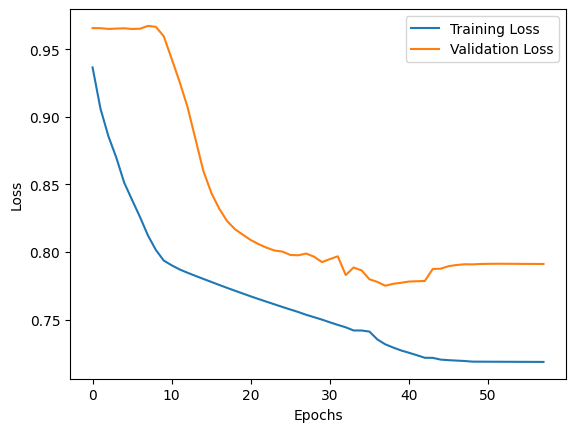

In [16]:
import pickle
import matplotlib.pyplot as plt

with open("C:\\Projects Datasets\\model_details\\history.pkl", "rb") as f:
    history_dict = pickle.load(f)

plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


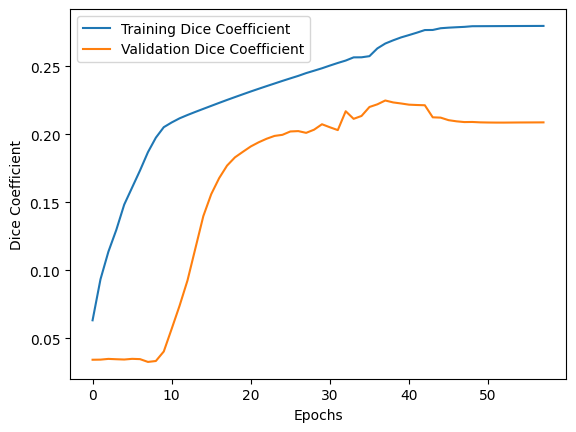

In [18]:
import matplotlib.pyplot as plt

plt.plot(history_dict['dice_coef'], label='Training Dice Coefficient')
plt.plot(history_dict['val_dice_coef'], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


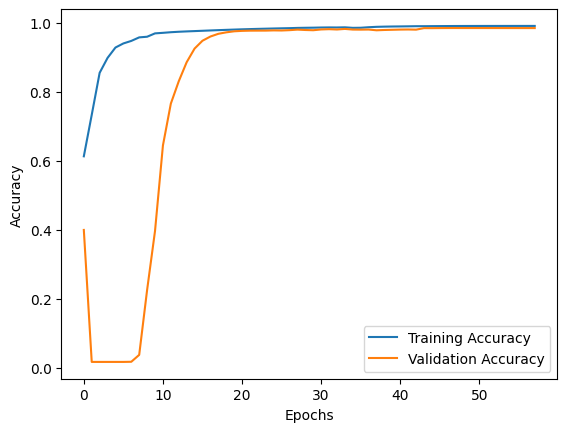

In [17]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
print("Final Training Dice:", history_dict['dice_coef'][-1])
print("Final Validation Dice:", history_dict['val_dice_coef'][-1])




Final Training Dice: 0.27984189987182617
Final Validation Dice: 0.20888327062129974


In [67]:

IMG_SIZE = 256  # must match training

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

test_x = np.array([load_image(p) for p in test_x])

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

test_y = np.array([load_mask(p) for p in test_y])

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)
print(model.input_shape)


error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'imread'
> Overload resolution failed:
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object


(176, 256, 256, 9)

In [62]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

model = load_model(
    "C:\\Projects Datasets\\model_details\\model.h5",
    custom_objects={"dice_coef": dice_coef},
    compile=False
)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",  # or dice_loss
    metrics=["accuracy", dice_coef]
)

loss, accuracy, dice = model.evaluate(test_x, test_y)

print(f"Loss is {loss}")
print(f"Accuracy is {accuracy}")
print(f"Dice_Coef is {dice}")


ValueError: in user code:

    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "UNET" "                 f"(type Functional).
    
    Input 0 of layer "conv2d_15" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "UNET" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None


In [ ]:
!pip install pandas


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV log
csv_path = "C:\\Projects Datasets\\model_details\\log.csv"
log_data = pd.read_csv(csv_path)

# Inspect available columns
print(log_data.columns)


Index(['epoch', 'accuracy', 'dice_coef', 'loss', 'lr', 'val_accuracy',
       'val_dice_coef', 'val_loss'],
      dtype='object')


In [ ]:
#https://github.com/nikhilroxtomar/Brain-Tumor-Segmentation-in-TensorFlow-2.0

In [60]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


In [26]:
model = load_model("C:\\Projects Datasets\\model_details\\model.h5",
                   custom_objects={"dice_coef": dice_coef},
                   compile=False)


In [45]:
import cv2
import numpy as np

# Load image
img_path = "C:\\Projects Datasets\\model_details\\1111.jpg"
image = cv2.imread(img_path)              # BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Resize to model input size
image_resized = cv2.resize(image, (256, 256))

# Normalize to [0,1]
image_norm = image_resized / 255.0

# Add batch dimension
input_tensor = np.expand_dims(image_norm, axis=0)   # shape (1, 256, 256, 3)


In [46]:
pred_mask = model.predict(input_tensor)

# Remove batch dimension
pred_mask = pred_mask[0]

# Threshold (convert probabilities to binary mask)
binary_mask = (pred_mask > 0.5).astype(np.uint8)


1/1 [==============================] - 0s 28ms/step


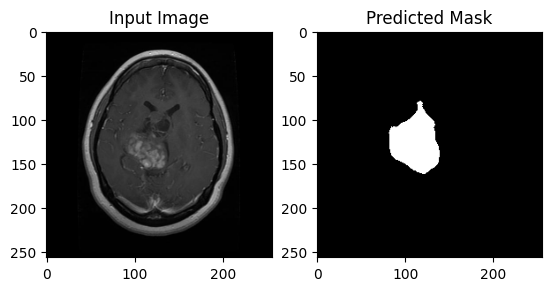

In [47]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(binary_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")

plt.show()
